In [34]:
import voxelmon
import polars as pl
from skimage import segmentation,feature,restoration,exposure,morphology
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import median_filter,gaussian_filter1d,gaussian_filter
import plotly.graph_objects as go

In [2]:
points,crs = voxelmon.open_file_pdal('../test_data/USGS_LPC_CA_SierraNevada_B22_10SFJ6362.laz',)
                                 #bounds='([663770, 663870], [4362360, 4362460])')
#points = pl.read_csv(,columns=['//X','Y','Z','hag','pad'],null_values='nan')
#points = points.rename({'//X':'X'})
points = points.filter(pl.col('X').gt(663770) & pl.col('X').lt(663870) & pl.col('Y').gt(4362360) & pl.col('Y').lt(4362460))
points

X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,GpsTime,ScanChannel,HeightAboveGround
f64,f64,f64,u16,u8,u8,u8,u8,u8,u8,u8,u8,u8,f32,u8,u16,f64,u8,f64
663869.98,4.3624e6,528.57,27612,2,2,0,0,2,0,0,0,0,-17.808001,0,2109,3.2173e8,0,0.0
663869.51,4.3624e6,528.73,25825,3,3,0,0,1,0,0,0,0,-17.82,0,2109,3.2173e8,0,0.123161
663868.99,4.3624e6,528.75,18350,4,4,0,0,2,0,0,0,0,-17.837999,0,2109,3.2173e8,0,0.0
663869.26,4.3624e6,532.94,31077,2,3,0,0,1,0,0,0,0,-17.862,0,2109,3.2173e8,0,4.278298
663869.04,4.3624e6,530.18,22054,4,5,0,0,1,0,0,0,0,-17.837999,0,2109,3.2173e8,0,1.468832
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
663770.7,4.362459e6,541.24,49637,1,1,1,0,2,0,0,0,0,22.746,1,2111,3.2173e8,1,0.0
663771.12,4.3625e6,541.16,49462,1,1,1,0,2,0,0,0,0,22.757999,1,2111,3.2173e8,1,0.0
663770.21,4.3625e6,541.23,48444,1,1,1,0,1,0,0,0,0,22.74,1,2111,3.2173e8,1,0.005045


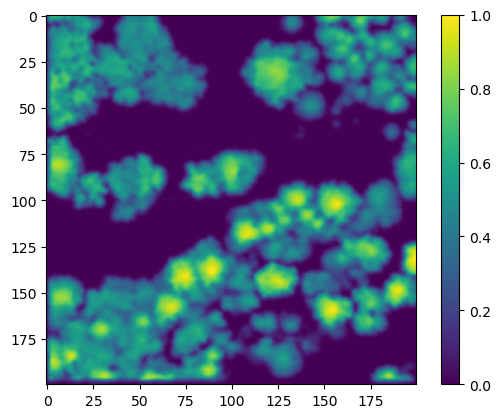

In [36]:
chm = voxelmon.bin2D(points[['X','Y','HeightAboveGround']].to_numpy(),pl.max('z'),.5)
idx_missing = np.argwhere(np.isnan(chm))
for idx in idx_missing:
    chm[idx[0], idx[1]] = np.nanmedian(chm[idx[0] - 1:idx[0] + 1, idx[1] - 1:idx[1] + 1])
chm = exposure.rescale_intensity(chm, out_range=(0, 1))
chm = restoration.denoise_bilateral(chm, win_size=5, sigma_color=1, sigma_spatial=.5)
chm = gaussian_filter(chm,1)
chm = exposure.equalize_adapthist(chm, 9)
plt.imshow(chm)
plt.colorbar()

## Segment in 2D with PAI

In [44]:
#blobs=feature.blob_dog(chm,min_sigma=1,max_sigma=50,threshold=.05,overlap=.2)
blobs = feature.peak_local_max(chm,min_distance=3,threshold_abs=.1)
#blobs=feature.blob_dog(chm,min_sigma=.3,max_sigma=20,threshold_rel=.5,overlap=.5)
len(blobs)

137

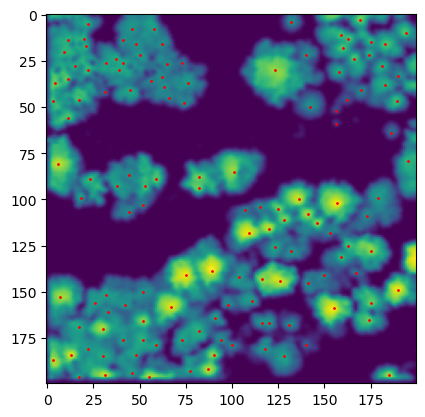

In [48]:
plt.imshow(chm)
plt.scatter(blobs[:,1],blobs[:,0],s=1,c='r')

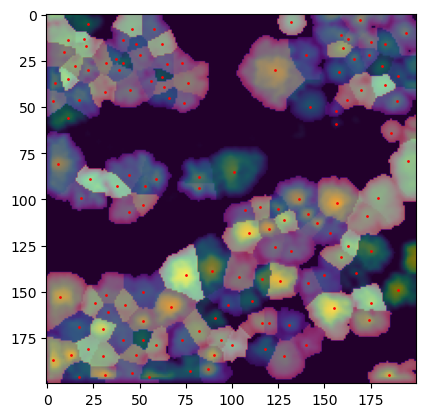

In [53]:
np.random.shuffle(blobs)
blobs = np.round(blobs).astype(int)
xs, ys = blobs[:, 0], blobs[:, 1]
seeds = np.zeros(chm.shape, dtype=int)
# Fill empty space with -1
seeds[chm<=.01] = -1
# Assign unique labels for seeds starting from 1 (0 is unclassified)
labels = np.arange(1, len(ys) + 1)
seeds[xs,ys] = labels

# Segment
regions = segmentation.random_walker(chm,seeds,beta=130)
plt.imshow(chm)
plt.scatter(blobs[:,1],blobs[:,0],s=1,c='r')
plt.imshow(regions,alpha=0.5,cmap='magma')